In [1]:
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
import torch
import random
from sklearn.manifold import TSNE
from sklearn.metrics import *
from matplotlib import pyplot as plt
import numpy as np
import sqlite3

In [2]:
def diameter(pts):
    # need at least 3 points to construct the convex hull
    if pts.shape[0] <= 1:
        return 0
    if pts.shape[0] == 2:
        return ((pts[0] - pts[1])**2).sum()
    # two points which are fruthest apart will occur as vertices of the convex hull
    hull = spatial.ConvexHull(pts)
    candidates = pts[spatial.ConvexHull(pts).vertices]
    return spatial.distance_matrix(candidates, candidates).max()

def dunn_index(pts, labels, centroids):
    # O(k n log(n)) with k clusters and n points; better performance with more even clusters
    max_intracluster_dist = max(diameter(pts[labels==i]) for i in np.unique(labels))
    # O(k^2) with k clusters; can be reduced to O(k log(k))
    # get pairwise distances between centroids
    cluster_dmat = spatial.distance_matrix(centroids, centroids)
    # fill diagonal with +inf: ignore zero distance to self in "min" computation
    np.fill_diagonal(cluster_dmat, np.inf)
    min_intercluster_dist = cluster_sizes.min()
    return min_intercluster_dist / max_intracluster_dist

In [3]:
con = sqlite3.connect('witt.db')

In [4]:
cur = con.cursor()

In [5]:
cur.execute('SELECT Category, COUNT(*) AS size FROM Categories GROUP BY Category ORDER BY size DESC')

In [6]:
cur.fetchall()

[('software', 4104),
 ('library', 2101),
 ('framework', 1578),
 ('tool', 1288),
 ('null', 1099),
 ('systems', 812),
 ('programming-language', 687),
 ('platform', 646),
 ('company', 634),
 ('language', 587),
 ('class', 478),
 ('service', 449),
 ('plugin', 430),
 ('component', 420),
 ('application', 395),
 ('api', 395),
 ('program', 374),
 ('extension', 349),
 ('functions', 336),
 ('file-format', 318),
 ('os', 314),
 ('method', 313),
 ('engine', 306),
 ('protocols', 293),
 ('server', 285),
 ('ide', 274),
 ('project', 268),
 ('interface', 263),
 ('format', 249),
 ('feature', 231),
 ('web-framework', 226),
 ('standard', 221),
 ('technique', 220),
 ('algorithm', 208),
 ('module', 204),
 ('website', 203),
 ('environment', 198),
 ('utility', 194),
 ('database', 190),
 ('toolkit', 187),
 ('programming', 184),
 ('product', 183),
 ('editor', 173),
 ('technology', 164),
 ('file', 160),
 ('manager', 158),
 ('way', 156),
 ('cms', 156),
 ('solution', 150),
 ('term', 149),
 ('specification', 148),
 (

In [7]:
cur = con.cursor()
cur.execute('SELECT Tag FROM Categories WHERE Category = "programming-language"')
results = cur.fetchall()
results

[('javascript',),
 ('java',),
 ('c#',),
 ('php',),
 ('python',),
 ('c++',),
 ('sql',),
 ('objective-c',),
 ('c',),
 ('r',),
 ('ruby',),
 ('swift',),
 ('vb.net',),
 ('vba',),
 ('python-3.x',),
 ('python-2.7',),
 ('scala',),
 ('excel-vba',),
 ('swing',),
 ('linq',),
 ('perl',),
 ('powershell',),
 ('typescript',),
 ('c++11',),
 ('actionscript-3',),
 ('haskell',),
 ('xslt',),
 ('dom',),
 ('assembly',),
 ('c#-4.0',),
 ('awk',),
 ('groovy',),
 ('sed',),
 ('swift3',),
 ('vbscript',),
 ('clojure',),
 ('linq-to-sql',),
 ('lua',),
 ('ecmascript-6',),
 ('java-8',),
 ('coffeescript',),
 ('vb6',),
 ('access-vba',),
 ('actionscript',),
 ('swift2',),
 ('fortran',),
 ('erlang',),
 ('dart',),
 ('qml',),
 ('applescript',),
 ('scheme',),
 ('lisp',),
 ('elixir',),
 ('glsl',),
 ('jstl',),
 ('ocaml',),
 ('linq-to-xml',),
 ('c++14',),
 ('processing',),
 ('shader',),
 ('common-lisp',),
 ('xslt-1.0',),
 ('vhdl',),
 ('racket',),
 ('wolfram-mathematica',),
 ('verilog',),
 ('julia-lang',),
 ('elisp',),
 ('sparql'

In [8]:
results = np.array(results).squeeze()

In [9]:
results

array(['javascript', 'java', 'c#', 'php', 'python', 'c++', 'sql',
       'objective-c', 'c', 'r', 'ruby', 'swift', 'vb.net', 'vba',
       'python-3.x', 'python-2.7', 'scala', 'excel-vba', 'swing', 'linq',
       'perl', 'powershell', 'typescript', 'c++11', 'actionscript-3',
       'haskell', 'xslt', 'dom', 'assembly', 'c#-4.0', 'awk', 'groovy',
       'sed', 'swift3', 'vbscript', 'clojure', 'linq-to-sql', 'lua',
       'ecmascript-6', 'java-8', 'coffeescript', 'vb6', 'access-vba',
       'actionscript', 'swift2', 'fortran', 'erlang', 'dart', 'qml',
       'applescript', 'scheme', 'lisp', 'elixir', 'glsl', 'jstl', 'ocaml',
       'linq-to-xml', 'c++14', 'processing', 'shader', 'common-lisp',
       'xslt-1.0', 'vhdl', 'racket', 'wolfram-mathematica', 'verilog',
       'julia-lang', 'elisp', 'sparql', 'xquery', 'c#-3.0', 'haml',
       'word-vba', 'facebook-fql', 'xslt-2.0', 'cython', 'aop',
       'matlab-figure', 'python-3.5', 'java-7', 'aspectj', 'python-3.4',
       'el', 'plpgsql',

In [10]:
cur = con.cursor()
cur.execute('SELECT Tag FROM Categories WHERE Category = "website"')
results2 = cur.fetchall()
results2 = np.array(results2).squeeze()
results2

array(['google-maps', 'amazon-web-services', 'google-maps-api-3',
       'amazon-s3', 'gwt', 'google-analytics', 'youtube', 'google-api',
       'google-drive-sdk', 'gmail', 'google-cloud-platform', 'bitbucket',
       'gitlab', 'google-plus', 'google-cloud-storage', 'prism',
       'openstreetmap', 'google-chrome-app', 'html5-audio', 'blogger',
       'tumblr', 'amazon-cloudfront', 'google-apps', 'jsfiddle',
       'google-maps-api-2', 'google-fusion-tables', 'onedrive', 'vimeo',
       'wiki', 'google-form', 'marker', 'google-translate', 'ebay',
       'forum', 'google-webmaster-tools', 'yahoo-finance', 'bing',
       'yahoo-api', 'reddit', 'zope', 'portal', 'freebase', 'amazon-mws',
       'google-search-api', 'google-apps-marketplace',
       'google-geocoding-api', 'universal-analytics', 'tweets', 'twitch',
       'skin', 'gcp', 'mechanicalturk', 'google-analytics-v4', 'skinning',
       'article', 'imgur', 'hotmail', 'chrome-web-store', 'skydrive',
       'aws-code-deploy', 'goog

In [11]:
x = results.tolist()
y = results2.tolist()
x.extend(y)
_results = x

In [12]:
_results = [x.split('-')[0] for x in _results]

In [13]:
_results = list(set(_results))

In [14]:
model = AutoModel.from_pretrained('../models/full/bert-base-uncased/checkpoint-250000/')
tok = AutoTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at ../models/full/bert-base-uncased/checkpoint-250000/ were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ../models/full/bert-base-uncased/checkpoint-250000/ and are newly initial

In [15]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [16]:
vectors = []
words = []

for x in _results:
    encoded_input = tok(x, return_tensors='pt')
    model_output = model(**encoded_input)

    vectors.append(mean_pooling(model_output, encoded_input['attention_mask']).detach().numpy())
    words.append(x)

print(len(vectors), vectors[0].shape)
vectors = np.array(vectors)

680 (1, 768)


In [17]:
vectors = vectors.squeeze()
vectors.shape

(680, 768)

In [18]:
tsne = TSNE()
vectors = tsne.fit_transform(vectors)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [19]:
vectors.shape

(680, 2)

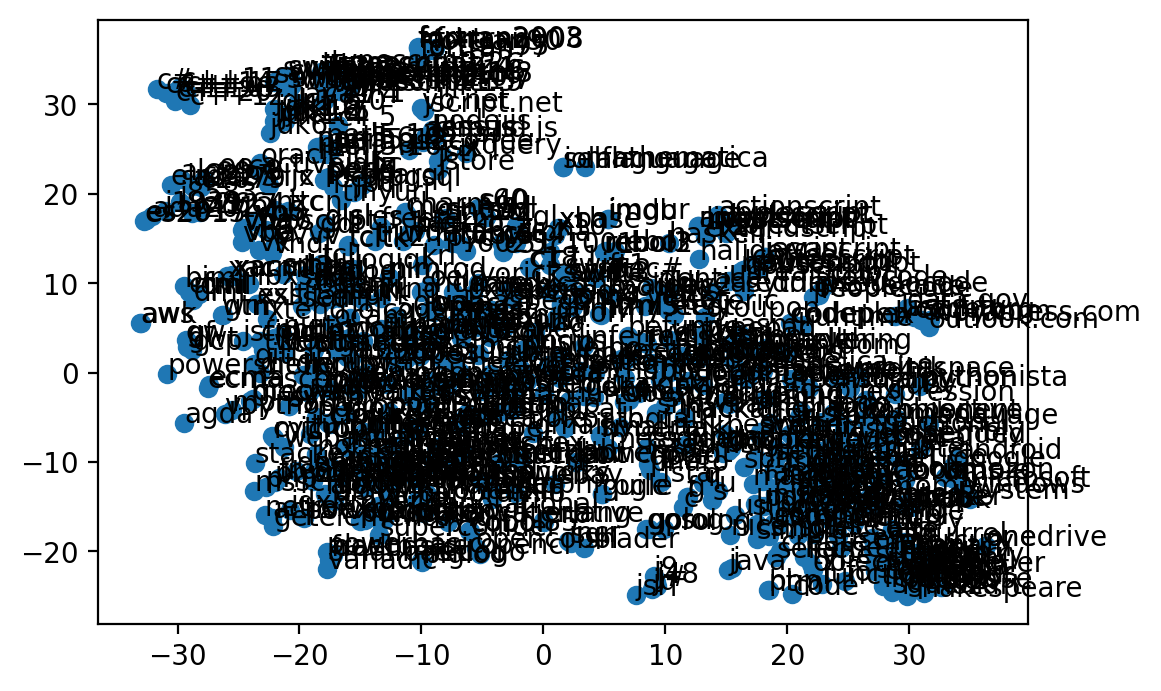

In [20]:
plt.figure(dpi=200)
plt.scatter(vectors.T[0], vectors.T[1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(vectors[i][0], vectors[i][1]))

## Do this with a subset

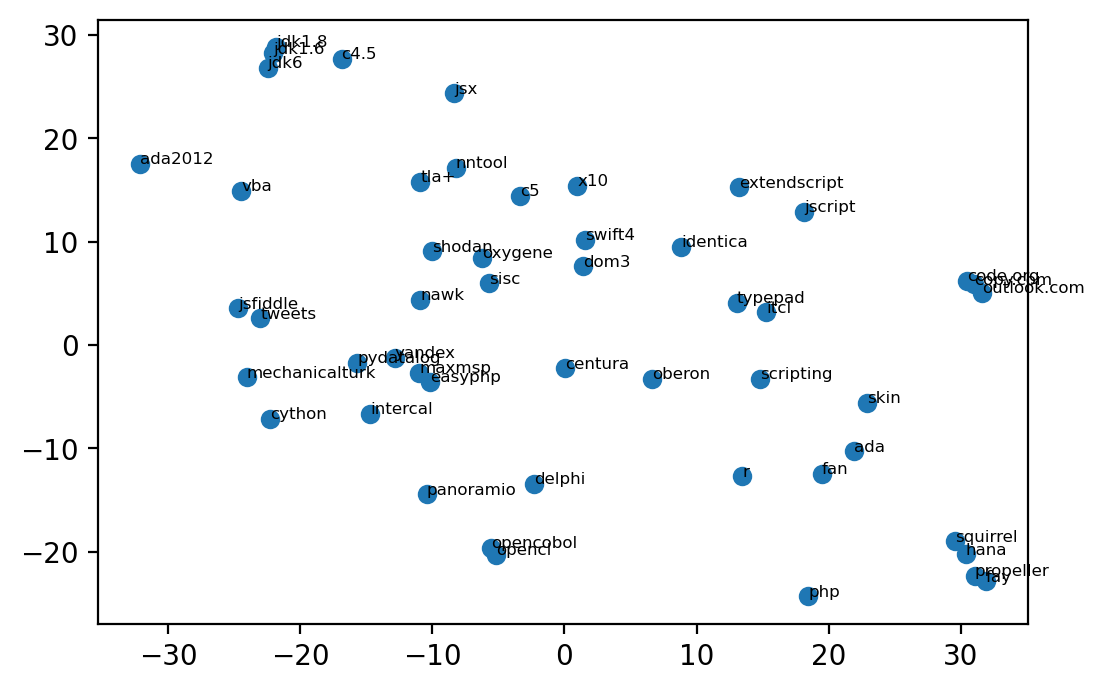

In [21]:
plt.figure(dpi=200)
plt.scatter(vectors[:50].T[0], vectors[:50].T[1])
for i, word in enumerate(words[:50]):
    plt.annotate(word, xy=(vectors[:50][i][0], vectors[:50][i][1]), fontsize=6)

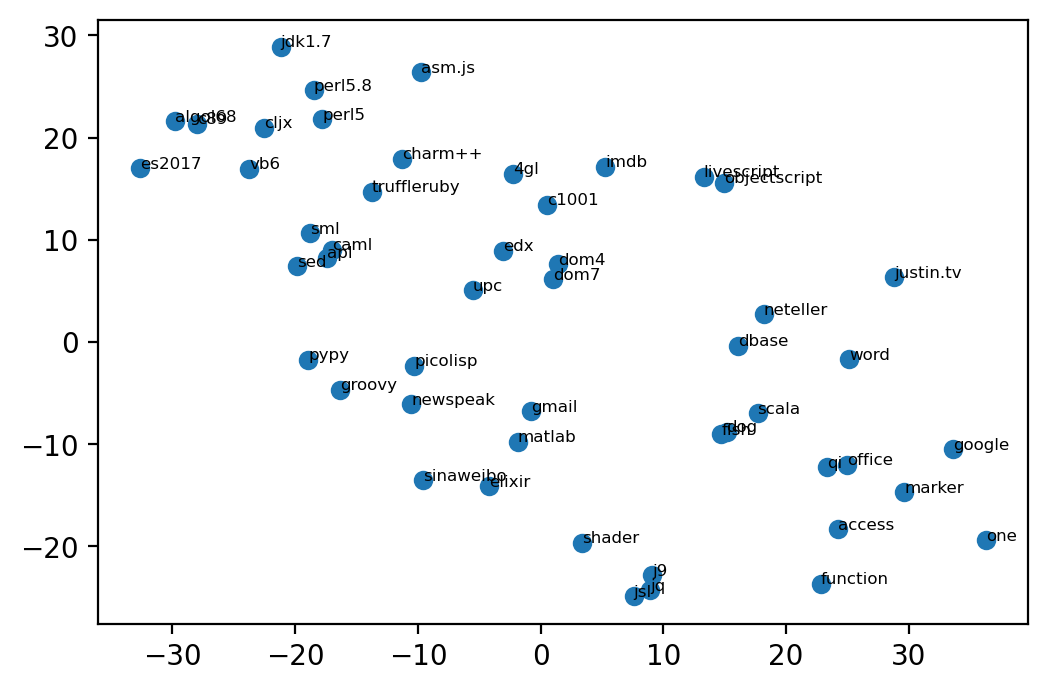

In [22]:
plt.figure(dpi=200)
plt.scatter(vectors[50:100].T[0], vectors[50:100].T[1])
for i, word in enumerate(words[50:100]):
    plt.annotate(word, xy=(vectors[50:100][i][0], vectors[50:100][i][1]), fontsize=6)

In [23]:
print(words[50:100])

['pypy', 'c1001', 'qi', 'matlab', 'jsl', 'newspeak', 'justin.tv', 'livescript', 'google', 'j9', '4gl', 'jq', 'algol68', 'c89', 'office', 'vb6', 'cljx', 'sinaweibo', 'shader', 'scala', 'dom4', 'function', 'upc', 'sml', 'elixir', 'objectscript', 'charm++', 'neteller', 'apl', 'one', 'word', 'es2017', 'fish', 'jdk1.7', 'edx', 'dog', 'dbase', 'caml', 'groovy', 'marker', 'picolisp', 'access', 'perl5.8', 'perl5', 'imdb', 'truffleruby', 'gmail', 'sed', 'dom7', 'asm.js']


In [25]:
cat_to_words = {}

cur = con.cursor()
cur.execute('SELECT Category, COUNT(*) AS size FROM Categories GROUP BY Category')
categories = cur.fetchall()

for cat, size in categories:
    if size == 0:
        continue
        
    cur = con.cursor()
    cur.execute(f'SELECT Tag FROM Categories WHERE Category = "{cat}"')
    results = cur.fetchall()
    
    if len(results) > 10:
        cat_to_words[cat] = np.array(results).squeeze().tolist()

In [27]:
cat_to_words

{'act': ['optimization',
  'design',
  'installation',
  'pattern-matching',
  'install',
  'iteration',
  'bit-manipulation',
  'zoom',
  'monitoring',
  'obfuscation',
  'matching',
  'centering',
  'shuffle',
  'boot',
  'password-encryption',
  'decompression',
  'tagging',
  'double-click',
  'screen-capture',
  'right-click',
  'database-partitioning',
  'pattern-recognition',
  'seek',
  'function-calls',
  'downcasting',
  'trading',
  'email-templates',
  'string-conversion',
  'microbenchmark',
  'document-classification',
  'video-editing',
  'formal-verification',
  'tethering',
  'reinstall',
  'port-scanning',
  'url-masking',
  'preemption',
  'downcast',
  'document-conversion',
  'screencast',
  'fraud-prevention',
  'oxm',
  'domain-masking',
  'conform',
  'coalescing',
  'abuse',
  'server-migration',
  'backgrounding',
  'parking',
  'bit-fiddling',
  'custom-installation'],
 'algorithm': ['algorithm',
  'apache-spark',
  'mapreduce',
  'apache-spark-sql',
  'aes',

In [17]:
def embed_words(words: list):
    vectors = []

    for x in words:
        encoded_input = tok(x, return_tensors='pt')
        model_output = model(**encoded_input)

        vectors.append(mean_pooling(model_output, encoded_input['attention_mask']).detach().numpy())

    return np.array(vectors).squeeze()

In [29]:
def get_labeled_dataset(vec1: np.ndarray, vec2: np.ndarray):
    return np.concatenate((vec1, vec2)), np.concatenate((np.zeros((len(vec1))), np.ones((len(vec2)))))

In [30]:
def get_dataset_from_multi_vectors(vectors: list):
    X = []
    y = []
    
    c = 0
    for v in vectors:
        X.extend(v)
        y.extend([c] * len(v))
        c += 1
    
    return X, y

In [32]:
bar = tqdm(total=len(cat_to_words))

vectors = []
for cat, words in cat_to_words.items():
    vectors.append(embed_words(words))
    bar.update(1)
            
X, y = get_dataset_from_multi_vectors(vectors)
calinski_harabasz_score(X, y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/108 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [35]:
def intrinsic_eval():
    bar = tqdm(total=100)
    scores = []
    counter = 0
    
    for cat1, words1 in random.sample(list(cat_to_words.items()), len(cat_to_words)):
        for cat2, words2 in random.sample(list(cat_to_words.items()), len(cat_to_words)):
            if cat1 < cat2:
                vec1 = embed_words(words1)
                vec2 = embed_words(words2)

                X, y = get_labeled_dataset(vec1, vec2)
                score = calinski_harabasz_score(X, y)
                print(davies_bouldin_score(X, y))
                scores.append(score)
                counter += 1

                if counter == 100:
                    return scores

                bar.update(1)

In [37]:
intrinsic_eval()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100 [00:00<?, ?it/s]

7.072453590566592
7.422859735770389
9.543702027895757
10.99464834970529
2.8196692579547475
6.271849358923303
6.402635610128408
7.73125277558683
8.204568652616807
4.9705364765951865


KeyboardInterrupt: 

In [111]:
np.median(_)

2.4552635129089513

In [29]:
def compare_topics(topic1: str, topic2: str):
    v1 = embed_words(cat_to_words[topic1])
    v2 = embed_words(cat_to_words[topic2])
        
    y = [0] * len(v1)
    y.extend([1] * len(v2))
    return calinski_harabasz_score(np.concatenate((v1, v2)), y), davies_bouldin_score(np.concatenate((v1, v2)), y)

### These should be different (high CH, low DB)

In [30]:
compare_topics('web-framework', 'machine-learning')

(2.5918038679413575, 4.9714009819400955)

In [31]:
compare_topics('data-structure', 'software')

(16.65899636058501, 5.484511976301262)

In [32]:
compare_topics('software', 'null')

(20.906409562424955, 12.865706059731915)

### These should be the same (low CH, high DB)

In [33]:
compare_topics('software', 'product')

(4.835762894883836, 11.946448543948831)

In [34]:
compare_topics('library', 'framework')

(19.06320029224796, 13.701260784965822)

In [35]:
compare_topics('framework', 'api')

(7.643193172928663, 12.772781712566786)

In [36]:
compare_topics('ide', 'tool')

(21.079911739287923, 6.487847369688894)

### Compare ratios

In [37]:
def check_ratio(topic1: str, topic2: str, topic3: str):
    """
    Checks the ratio of (topic1, topic2) and (topic1, topic3). topic1 and topic2 should be
    *different*, while topic1 and topic3 should be *similar*.
    
    A good result will have *high* first value and *low* second value.
    """
    ch1, db1 = compare_topics(topic1, topic2)
    ch2, db2 = compare_topics(topic1, topic3)
    
    return ch1 / ch2, db1 / db2

In [38]:
check_ratio('software', 'null', 'product')

(4.3232908678263815, 1.0769481835878922)

In [39]:
check_ratio('ide', 'data-structure', 'tool')

(0.9435343406134941, 0.6488284227738335)

In [40]:
check_ratio('technique', 'plugin', 'algorithm')

(3.5257865560935238, 0.6217064639827096)

In [41]:
check_ratio('technique', 'ide', 'technique')

(203808319531.83215, 5.598845087199642e-08)